In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf

tfe = tf.contrib.eager

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Eager Execution
use_tf_eager = True #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    pass


def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [3]:
def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

In [4]:
reset_sess()

# Coin-flip example

In [54]:
tfd.Bernoulli(probs=.6).prob([.2])

<tf.Tensor: id=8341, shape=(1,), dtype=float32, numpy=array([0.43378872], dtype=float32)>

In [115]:
probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
n_trials_ = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000]

coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5)
coin_flip_data = coin_flip_prior.sample(n_trials_[-1])

n_trials_unpacked = tf.unstack(tf.constant(n_trials_))
counted = []

for k, N in enumerate(n_trials_):
    result_tensor = tf.reduce_sum(coin_flip_data[:N])
    counted.append(result_tensor)

headcounts = tf.stack(counted, 0)
observed_head_probs = []

for k, N in enumerate(n_trials_):
    result_tensor = tfp.distributions.Beta(
                        concentration1 = tf.to_float(1 + headcounts[k]),
                        concentration0 = tf.to_float(1 + n_trials_[k] - headcounts[k])).prob(probs_of_heads)
    observed_head_probs.append(result_tensor)

observed_probs_heads = tf.stack(observed_head_probs, 0)

In [116]:
[
    n_trials_unpacked_,
    coin_flip_data_,
    probs_of_heads_,
    headcounts_,
    observed_probs_heads_,
] = evaluate([
    n_trials_unpacked,
    coin_flip_data,
    probs_of_heads,
    headcounts,
    observed_probs_heads,
])

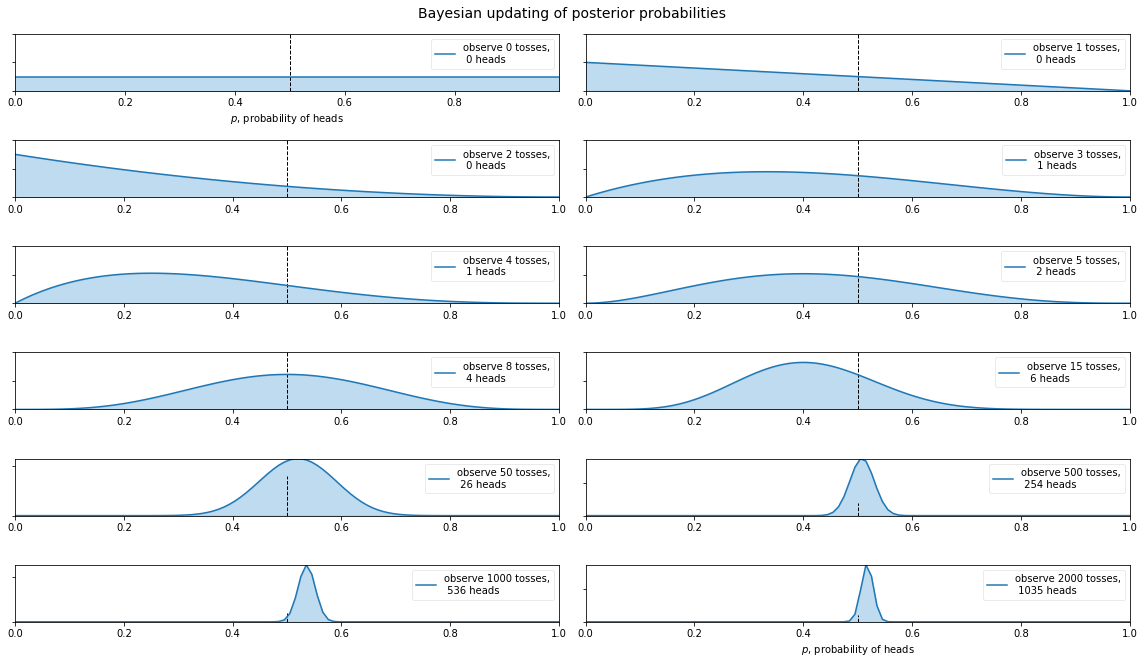

In [117]:
plt.figure(figsize=(16, 9))
for i in range(len(n_trials_)):
    sx = plt.subplot(len(n_trials_)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(n_trials_)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads_, observed_probs_heads_[i], 
             label="observe %d tosses,\n %d heads" % (n_trials_[i], headcounts_[i]))
    plt.fill_between(probs_of_heads_, 0, observed_probs_heads_[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

<tf.Tensor: id=26275, shape=(20,), dtype=float32, numpy=
array([ 0.       ,  0.5263158,  1.0526316,  1.5789474,  2.1052632,
        2.631579 ,  3.1578948,  3.6842108,  4.2105265,  4.736842 ,
        5.263158 ,  5.789474 ,  6.3157897,  6.8421054,  7.3684216,
        7.8947372,  8.421053 ,  8.947369 ,  9.473684 , 10.       ],
      dtype=float32)>

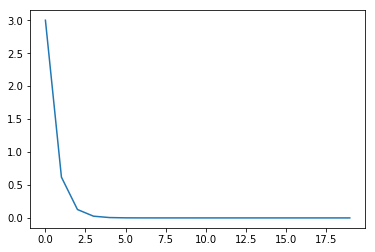

In [125]:
plt.plot(tfd.Exponential(rate=3).prob(tf.linspace(0., 10., 20)).numpy())

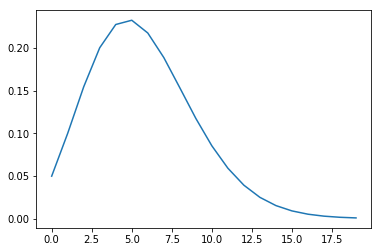

In [124]:
plt.plot(tfd.Poisson(rate=3).prob(tf.linspace(0., 10., 20)).numpy())

In [127]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
count_data_mean = tf.reduce_mean(count_data)
n_count_data = tf.shape(count_data)
count_of_text_msgs = tf.range(n_count_data[0])

# Convert from TF to numpy.

[
    count_data_, 
    count_data_mean_,
    n_count_data_, 
    count_of_text_msgs_,
] = evaluate([
    count_data, 
    count_data_mean,
    n_count_data,
    count_of_text_msgs,
])


# Set the chain's start state.
initial_chain_state = [
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]


def joint_log_prob(count_data, lambda_1, lambda_2, tau):
     tfd = tfp.distributions
 
     alpha = (1. / tf.reduce_mean(count_data))
     rv_lambda_1 = tfd.Exponential(rate=alpha)
     rv_lambda_2 = tfd.Exponential(rate=alpha)
 
     rv_tau = tfd.Uniform()
 

     lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.to_int32(tau * tf.to_float(tf.size(count_data)) <= tf.to_float(tf.range(tf.size(count_data)))))
     rv_observation = tfd.Poisson(rate=lambda_)
 
     return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
     )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=100000,
    num_burnin_steps=10000,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))

tau_samples = tf.floor(posterior_tau * tf.to_float(tf.size(count_data)))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(n_count_data)


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

evaluate(init_g)
evaluate(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_,
    expected_texts_per_day_,
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N,
    expected_texts_per_day,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.58712
final step size: 0.03069082647562027


In [44]:
import pydot
from itertools import chain
def tf_graph_to_dot(in_graph):
    dot = pydot.Dot()
    dot.set('rankdir', 'LR')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')
    all_ops = in_graph.get_operations()
    all_tens_dict = {k: i for i,k in enumerate(set(chain(*[c_op.outputs for c_op in all_ops])))}
    for c_node in all_tens_dict.keys():
        node = pydot.Node(c_node.name)#, label=label)
        dot.add_node(node)
    for c_op in all_ops:
        for c_output in c_op.outputs:
            for c_input in c_op.inputs:
                dot.add_edge(pydot.Edge(c_input.name, c_output.name))
    return dot

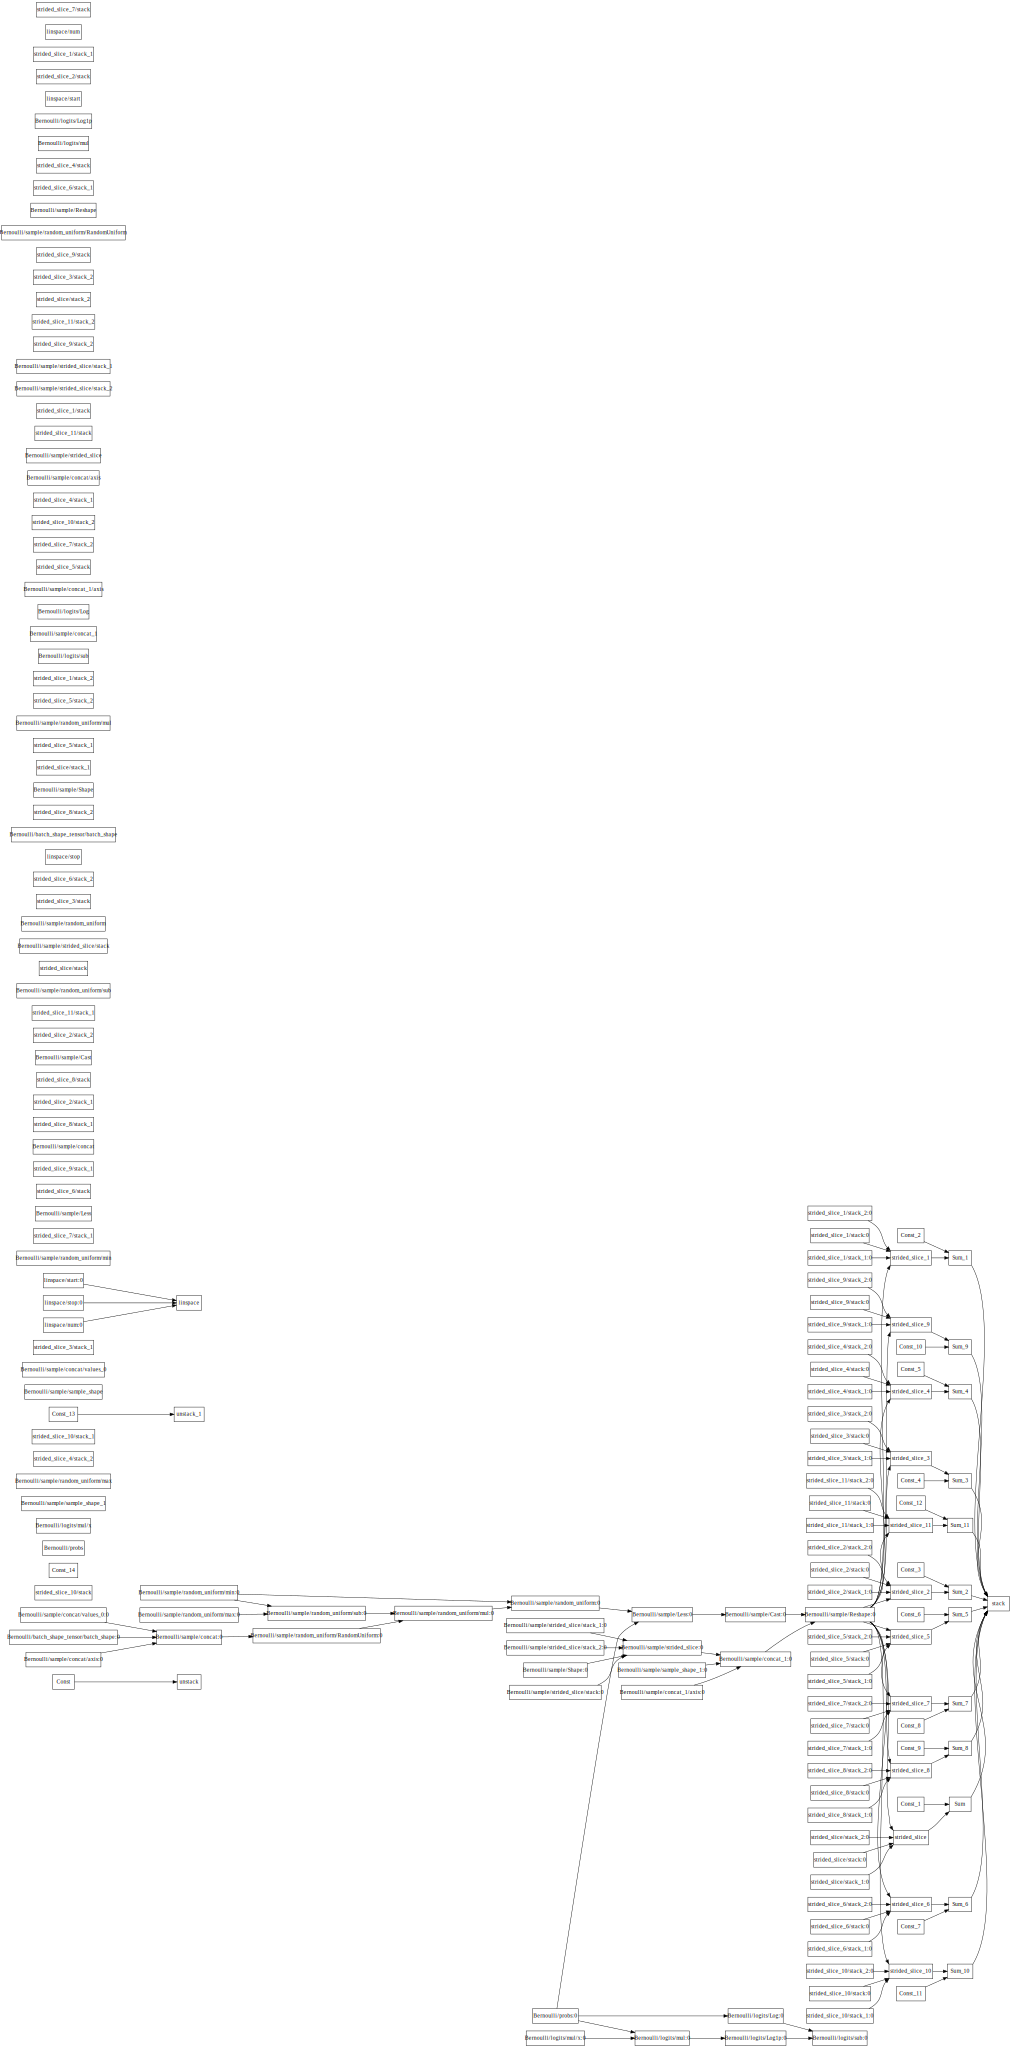

In [45]:
from IPython.display import SVG
# Define model
tf_graph_to_dot(tf.get_default_graph()).write_svg('simple_tf.svg')
SVG('simple_tf.svg')

In [29]:
show_graph(tf.get_default_graph().as_graph_def())

TypeError: '<stripped 48 bytes>' has type str, but expected one of: bytes

In [28]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))